## Pass and Fail likelihood

In [1]:
## Import libraries
import os
import gzip
import json
import datetime
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings

warnings.filterwarnings("ignore")
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

## Import dataframe

### Test 1

In [2]:
test_id = "28698040" # Pre-commit test

In [3]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [4]:
passing_train.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,12,2022-12-14T15:53:31Z,2022-12-14T15:54:12Z,3696463705,completed,success,41.0,28698040
1,28,2022-06-29T20:52:20Z,2022-06-29T20:52:49Z,2585823572,completed,success,29.0,28698040
2,7,2022-10-25T20:59:24Z,2022-10-25T21:00:05Z,3324245010,completed,success,41.0,28698040
3,6,2022-07-12T21:11:13Z,2022-07-12T21:11:42Z,2659424327,completed,success,29.0,28698040
4,23,2022-07-05T15:28:26Z,2022-07-05T15:29:06Z,2617219129,completed,success,40.0,28698040


In [5]:
failing_train.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,8,2022-10-11T15:27:59Z,2022-10-11T21:30:30Z,3228155174,completed,failure,21751.0,28698040
1,19,2022-09-27T19:49:11Z,2022-09-27T19:49:59Z,3138511295,completed,failure,48.0,28698040
2,0,2022-12-01T18:58:49Z,2022-12-01T18:59:25Z,3595655421,completed,failure,36.0,28698040
3,16,2022-11-16T19:04:40Z,2022-11-16T19:05:09Z,3482315892,completed,failure,29.0,28698040
4,6,2022-12-08T16:33:31Z,2022-12-08T16:33:57Z,3650200301,completed,failure,26.0,28698040


In [6]:
ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)

In [7]:
# time bucket passing and failing run durations into buckets of 10 seconds

In [8]:
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)

In [9]:
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)

In [10]:
# get frequency of how many tests lie in those time buckets

In [11]:
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())

In [12]:
p_vc

,run_duration_ranges
"(0.0, 10.0]",0
"(10.0, 20.0]",0
"(20.0, 30.0]",35
"(30.0, 40.0]",38
"(40.0, 50.0]",12
"(50.0, 60.0]",6
"(60.0, 70.0]",5
"(70.0, inf]",1


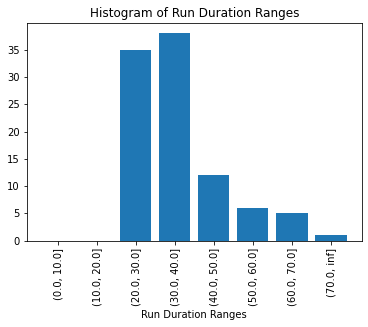

In [13]:
plt.bar(p_vc.index.astype(str), p_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

In [14]:
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

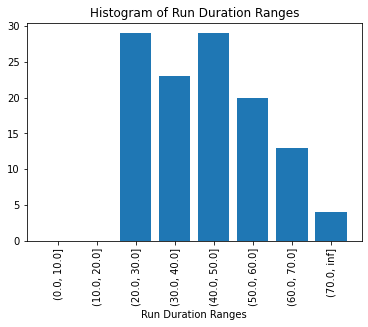

In [15]:
plt.bar(f_vc.index.astype(str), f_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

In [16]:
# for start of each time bucket get total number of tests which pass or fail after that point
# get the reverse cumulative sum for that

In [17]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [18]:
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [19]:
p_vc.head()

,run_duration_ranges,prefix_sum
"(0.0, 10.0]",0,97
"(10.0, 20.0]",0,97
"(20.0, 30.0]",35,97
"(30.0, 40.0]",38,62
"(40.0, 50.0]",12,24


In [20]:
f_vc.head()

,run_duration_ranges,prefix_sum
"(0.0, 10.0]",0,118
"(10.0, 20.0]",0,118
"(20.0, 30.0]",29,118
"(30.0, 40.0]",23,89
"(40.0, 50.0]",29,66


In [21]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,97,100.000000
"(10.0, 20.0]",0,97,100.000000
"(20.0, 30.0]",35,97,100.000000
"(30.0, 40.0]",38,62,63.917526
"(40.0, 50.0]",12,24,24.742268
"(50.0, 60.0]",6,12,12.371134
"(60.0, 70.0]",5,6,6.185567
"(70.0, inf]",1,1,1.030928


In [22]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,118,100.000000
"(10.0, 20.0]",0,118,100.000000
"(20.0, 30.0]",29,118,100.000000
"(30.0, 40.0]",23,89,75.423729
"(40.0, 50.0]",29,66,55.932203
"(50.0, 60.0]",20,37,31.355932
"(60.0, 70.0]",13,17,14.406780
"(70.0, inf]",4,4,3.389831


In [23]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

In [24]:
total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

In [25]:
joined['f_pct']

(0.0, 10.0]     54.883721
(10.0, 20.0]    54.883721
(20.0, 30.0]    54.883721
(30.0, 40.0]    58.940397
(40.0, 50.0]    73.333333
(50.0, 60.0]    75.510204
(60.0, 70.0]    73.913043
(70.0, inf]     80.000000
Name: f_pct, dtype: float64

In [26]:
joined['p_pct']

(0.0, 10.0]     45.116279
(10.0, 20.0]    45.116279
(20.0, 30.0]    45.116279
(30.0, 40.0]    41.059603
(40.0, 50.0]    26.666667
(50.0, 60.0]    24.489796
(60.0, 70.0]    26.086957
(70.0, inf]     20.000000
Name: p_pct, dtype: float64

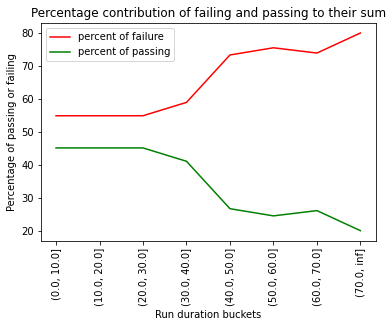

In [27]:
# plot the two series on the same graph
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')
plt.plot(joined.index.astype(str), joined['p_pct'], color='green', label='percent of passing')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of passing or failing')
plt.xticks(rotation=90) 

# set title and legend
plt.title('Percentage contribution of failing and passing to their sum')
plt.legend()

# show the plot
plt.show()

### Test 2

In [28]:
# test_id = "29176617" # Build and push image
test_id = "37149896" # File linting

In [29]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [30]:
ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)

In [31]:
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

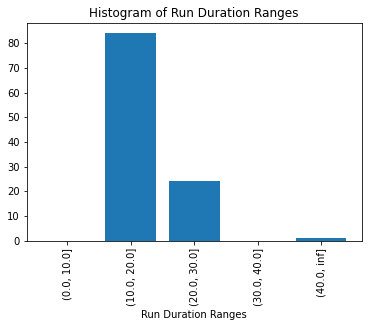

In [32]:
plt.bar(p_vc.index.astype(str), p_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

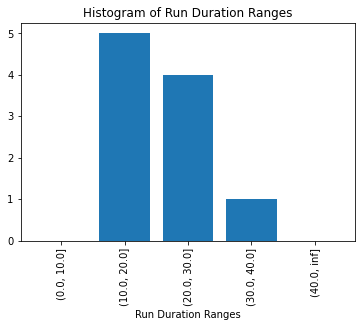

In [33]:
plt.bar(f_vc.index.astype(str), f_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

In [34]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [35]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,109,100.000000
"(10.0, 20.0]",84,109,100.000000
"(20.0, 30.0]",24,25,22.935780
"(30.0, 40.0]",0,1,0.917431
"(40.0, inf]",1,1,0.917431


In [36]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,10,100.0
"(10.0, 20.0]",5,10,100.0
"(20.0, 30.0]",4,5,50.0
"(30.0, 40.0]",1,1,10.0
"(40.0, inf]",0,0,0.0


In [37]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

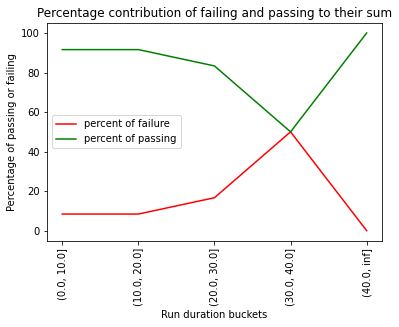

In [38]:
# plot the two series on the same graph
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')
plt.plot(joined.index.astype(str), joined['p_pct'], color='green', label='percent of passing')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of passing or failing')
plt.xticks(rotation=90) 

# set title and legend
plt.title('Percentage contribution of failing and passing to their sum')
plt.legend()

# show the plot
plt.show()

### Test 3

In [39]:
test_id = "37149895" # Spell Check

In [40]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [41]:
ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

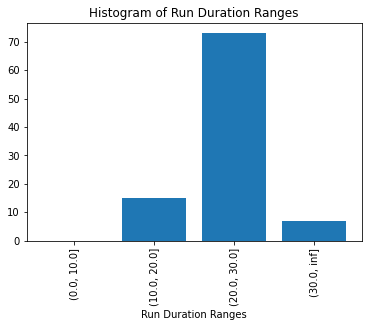

In [42]:
plt.bar(p_vc.index.astype(str), p_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

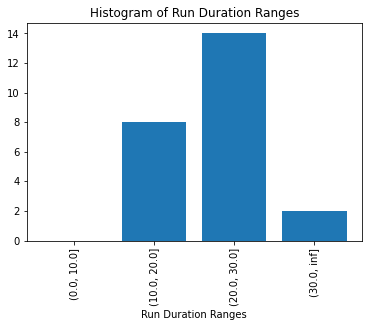

In [43]:
plt.bar(f_vc.index.astype(str), f_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

In [44]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [45]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,95,100.000000
"(10.0, 20.0]",15,95,100.000000
"(20.0, 30.0]",73,80,84.210526
"(30.0, inf]",7,7,7.368421


In [46]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,24,100.000000
"(10.0, 20.0]",8,24,100.000000
"(20.0, 30.0]",14,16,66.666667
"(30.0, inf]",2,2,8.333333


In [47]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

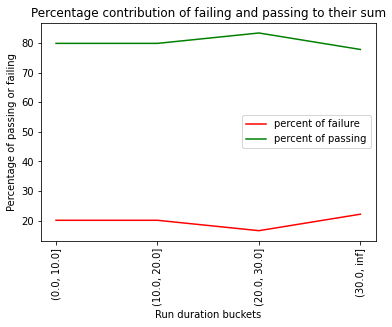

In [48]:
# plot the two series on the same graph
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')
plt.plot(joined.index.astype(str), joined['p_pct'], color='green', label='percent of passing')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of passing or failing')
plt.xticks(rotation=90) 

# set title and legend
plt.title('Percentage contribution of failing and passing to their sum')
plt.legend()

# show the plot
plt.show()

In the above graph we see that most of the tests are passing. The above graph is largely impacted by the number of passing and failing tests amongst all tests ie it is impacted by the number of passes and failures.

If we want to ignore the aspect of the number of tests passing and failing and only focus on the trend within the failing tests and the trens within the passing tests, we can get percent of percentages. Lets see how that graph looks.

In [49]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_percentage_f', 'prefix_sum_percentage_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_percentage_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_percentage_p'] / total * 100

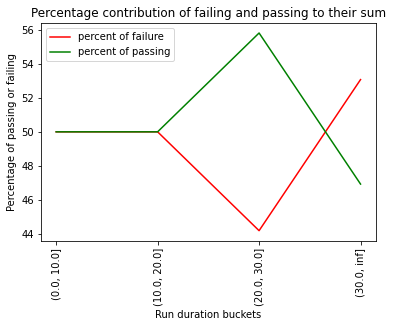

In [50]:
# plot the two series on the same graph
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')
plt.plot(joined.index.astype(str), joined['p_pct'], color='green', label='percent of passing')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of passing or failing')
plt.xticks(rotation=90) 

# set title and legend
plt.title('Percentage contribution of failing and passing to their sum')
plt.legend()

# show the plot
plt.show()

This above plot indicates that at a time duration 25, a test is more likely to fail than pass.

### Test 4: Lets do this for a much larger test dataset

In [51]:
# From the repo https://github.com/github/codeql
test_id = "39411153" #"Compile all queries using the latest stable CodeQL CLI"

In [52]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [53]:
# bucketing into 30 second intervals

ranges = np.arange(0, max(passing_train['run_duration'])+1, 30).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

---------------------

### IQR method to remove outliers

In [54]:
## Mostly thinking of removing this part, just kept it for now if we need to test out the methods after removing outliers

In [55]:
# q1 = passing_train['run_duration'].describe()['25%']
# q3 = passing_train['run_duration'].describe()['75%']
# iqr = q3 - q1
# outlier_threshold = q3 + 6.0 * iqr

In [56]:
# ranges = np.arange(0, int(outlier_threshold)+1, 30).tolist()
# ranges.append(np.inf)
# passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
# failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
# p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
# f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

------------------

In [57]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [58]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 30.0]",0,4528,100.000000
"(30.0, 60.0]",0,4528,100.000000
"(60.0, 90.0]",8,4528,100.000000
"(90.0, 120.0]",99,4520,99.823322
"(120.0, 150.0]",593,4421,97.636926
...,...,...,...
"(341820.0, 341850.0]",0,1,0.022085
"(341850.0, 341880.0]",0,1,0.022085
"(341880.0, 341910.0]",0,1,0.022085
"(341910.0, 341940.0]",0,1,0.022085


In [59]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 30.0]",10,368,100.000000
"(30.0, 60.0]",31,358,97.282609
"(60.0, 90.0]",72,327,88.858696
"(90.0, 120.0]",49,255,69.293478
"(120.0, 150.0]",48,206,55.978261
...,...,...,...
"(341820.0, 341850.0]",0,2,0.543478
"(341850.0, 341880.0]",0,2,0.543478
"(341880.0, 341910.0]",0,2,0.543478
"(341910.0, 341940.0]",0,2,0.543478


In [60]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

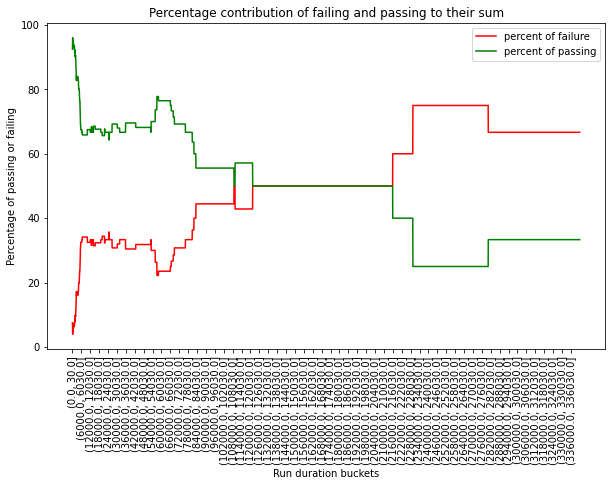

In [61]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')
plt.plot(joined.index.astype(str), joined['p_pct'], color='green', label='percent of passing')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of passing or failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Percentage contribution of failing and passing to their sum')
plt.legend()

# show the plot
plt.show()

In [62]:
def find_turning_point(s):

    # Find the point at which after which the test is 75% likely to fail 
    # and at all points after then it is never less than 60% likely to fail.
    # Can also parameterize these percentages
    
    sub = pd.Series()
    turning_point = 0
    for index, value in s[::-1].iteritems():
        if value > 60:
            sub.loc[index] = value
        else:
            if sub.empty:
                return 0
            elif not sub.empty:
                turning_point = (sub[::-1] >= 75).idxmax()
                return turning_point

In [63]:
tp = find_turning_point(joined['f_pct'])

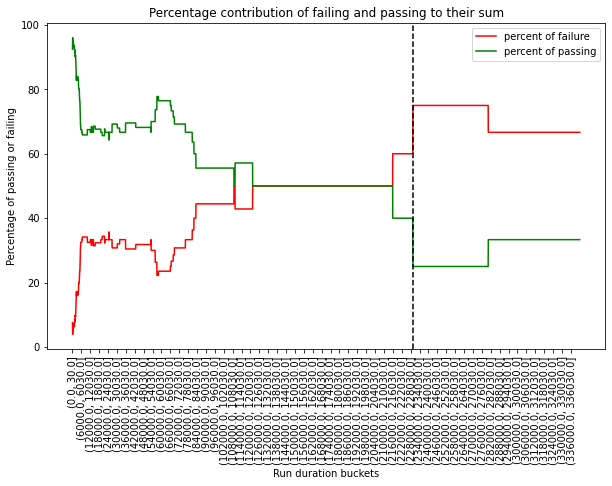

In [64]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')
plt.plot(joined.index.astype(str), joined['p_pct'], color='green', label='percent of passing')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of passing or failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Percentage contribution of failing and passing to their sum')
plt.legend()


x_position = joined.index.astype(str).tolist().index(str(tp))
plt.axvline(x=x_position, color='black', linestyle='--')

# show the plot
plt.show()

In [65]:
tp

Interval(229440.0, 229470.0, closed='right')

Let's say we pick x as the stopping point beyond which y % tests are likely to fail 

Lets evaluate how this does on the test dataset

In [66]:
passing_test = pd.read_csv("../data/processed/{}passing_test.csv".format(test_id))
failing_test = pd.read_csv("../data/processed/{}failing_test.csv".format(test_id))

In [67]:
passing_test.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,8,2023-02-03T15:16:11Z,2023-02-03T15:18:51Z,4085449911,completed,success,160.0,39411153
1,16,2023-03-09T10:43:24Z,2023-03-09T11:12:31Z,4373589410,completed,success,1747.0,39411153
2,1,2022-11-16T16:02:40Z,2022-11-16T16:06:19Z,3480995628,completed,success,219.0,39411153
3,20,2023-03-30T18:33:26Z,2023-03-30T18:35:50Z,4567807931,completed,success,144.0,39411153
4,29,2023-03-17T17:29:33Z,2023-03-17T17:35:11Z,4450078573,completed,success,338.0,39411153


In [68]:
failing_test.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,14,2023-03-28T10:39:18Z,2023-03-28T10:40:24Z,4542117817,completed,failure,66.0,39411153
1,21,2022-11-02T13:39:54Z,2022-11-02T14:04:54Z,3378016721,completed,failure,1500.0,39411153
2,4,2022-11-28T16:26:30Z,2022-11-28T16:27:25Z,3566698252,completed,failure,55.0,39411153
3,7,2022-11-28T16:22:30Z,2022-11-28T16:23:25Z,3566666479,completed,failure,55.0,39411153
4,28,2023-01-26T17:44:53Z,2023-01-26T17:47:31Z,4017737467,completed,failure,158.0,39411153


In [69]:
test_data = pd.concat([passing_test, failing_test], axis=0)

In [70]:
# Add new column with "success" or "failure" based on run_duration
test_data['predicted_status'] = np.where(test_data['run_duration'] > tp.left, 'failure', 'success')

In [71]:
# Calculate percentage of rows where "predicted_status" matches "conclusion"
accuracy = (test_data['predicted_status'] == test_data['conclusion']).sum() / len(test_data) * 100
print(f"Accuracy: {accuracy:.2f}%")

Match percentage: 92.24%
